# Homework I : Supervised Deep Learning - Regression

## Sabrina Giorgetti - 2013375

##  Index

1. [Introduction](#Introduction)<br>
    1.1 [Import](#Import)<br>
    1.2 [Dataset](#Dataset)<br>
2. [Regression](#Autoencoder)<br>
    2.1 [Model](#Intro)<br>
    2.3 [Trial](#Trial)<br>
3. [Optimization with cross-validation](#Optimization-with-cross-validation)<br>
    3.1 [Optuna-study](#Optuna-study)<br>
    3.2 [Study results](#Study-results)<br>
4. [Best model](#Best-model)<br>
    4.1 [Training](#Training)<br>
    4.2 [Prediction](#Prediction)<br>
5. [Visualization](#Visualization)<br>


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

# Introduction

Machine learning (ML) is a set of methods that give to a computer systems the ability to learn from training data to make predictions about novel data samples, if the training data are provided with the corresponding correct predictions, called labels, then we talk about supervised machine learning. 

Regression is a supervised machine learning algorithm in which one tries to find a relationship between independent variable $x$ and dependent variable $y$. In this homework, the aim is to approximate the trend of the scalar function:  

$$ y = f(x)$$ 
$$ x \rightarrow f(x) $$

with $ x \in R$ and $ f: R \rightarrow R $. This is achivable with a supervised training $D=\{x_{train},y_{train}\}$ of fully connected neural network (FCNN) such that $ y_{pred} \sim f(x) $ is the best approximation of the relation
between input and output. 

The implementation is carried out in a Python environment with a PyTorch framework, as an optimization tool Optuna is also used. The code and images can be found at the following link [Github repo](https://github.com/giorgettisabrina/NNDL/tree/main/homework1)

**Required tasks**

Grade: The maximum grade for this homework will be 8 points. Points will be assigned based on the correct implementation of the following items:
- 2 pt: implement basic regression and classification tasks
- 2 pt: explore advanced optimizers and regularization methods (both tasks)
- 1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
- 2 pt: implement CNN for classification task
- 1 pt: visualize weight histograms, activation profiles and receptive fields


## Import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm   
import random
import os

from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
import torchvision

import optuna

In [2]:
#Check if any GPU is available, otherwise use CPU  
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
seed = 2134
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


# Dataset 

The dataset provided, plotted below, has the following characteristic :
    
- Training set : 100 points
- Test set : 100 points
    
    
The training points are further divided into training data and validation data, the splitting size is set to 0.2, so in the end we have only 80 points for training and 20 for validation. One can notice that the training and test data are not distributed homogeneously and that there are intervals in which we have only training data and likewise with test set. Moreover the amount of data available is not much and we must take this into account if want to perform an hyperparameters optimization. 

In [4]:
#!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
#!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

In [5]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

In [6]:
class CsvDataset(Dataset):
    def __init__(self, csv_file: str, transform=None):
        self.transform = transform
        self.data = csv_file

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # sample: ('index', 'label) --> sample = (csv_file index elem, csv_file column element)
        sample = (self.data.iloc[idx][0], self.data.iloc[idx][1])
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())


In [7]:
train_split, val_split = train_test_split(train_df,test_size=0.2, shuffle= True,  random_state=seed)
train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

print('Number of samples in the train dataset:', len(train_split))
print('Number of samples in the validation dataset:', len(val_split))
print('Number of samples in the test dataset:', len(test_df))

Number of samples in the train dataset: 80
Number of samples in the validation dataset: 20
Number of samples in the test dataset: 100


In [27]:
composed_transform = transforms.Compose([ToTensor()])

train_data = CsvDataset(train_df, transform=composed_transform)
train_dataset = CsvDataset(train_split, transform=composed_transform)
val_dataset = CsvDataset(val_split, transform=composed_transform)
test_dataset= CsvDataset(test_df, transform=composed_transform)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=15, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)


With the Dataloader module we can define the batch size and enable shuffling for the training data.

SAMPLE AT INDEX 9
INPUT: -3.44016058929888
LABEL: 2.8657826429373463


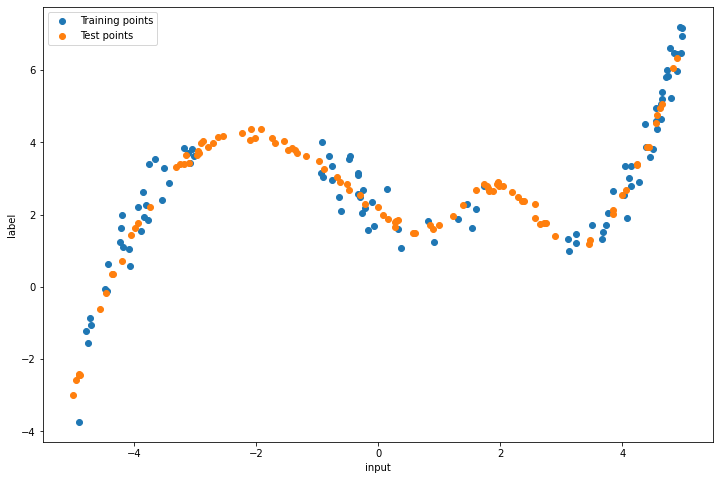

In [10]:
sample_index = 9
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

# Regression

## Model 

We built a *Net* class in which we define the model and also the training and evaluation loop. The model is a fully connected neural network with the following architecture:

- Input Layer of dimension one 
- First dense layer with *Nh1* hidden units
- Second dense layer with *Nh2* hidden units
- Output layer of dimension one 

as activation function the Rectified linear activation function (ReLU)is used. The loss function we want to minimize is the mean squared error (MSEloss) defined as : $L(y,y_{pred}) = \frac{1}{N} \sum_i^N (y_i -y_{pred})^2$.
In order to perform a first trial run, we choose *Adam* as the optimizer chosen with a learning rate equal to $10^{-3}$ and we also apply L2 regularization though the *weghit_norm* variable to prevent overfitting and force smaller weights values. 

In [11]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()
        # network definition with just its architecture  
        
    def forward(self, x, additional_out = -1):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x


    def train_step(self, train_dataloader, val_dataloader, param_dict):
        
        train_loss_log =[]
        val_loss_log = []

        epochs = param_dict['epochs']
        loss_fn = param_dict['loss']
    
        optimizer_name = param_dict['optimizer']
        lr = param_dict['lr']
        weight_norm = param_dict['weight_norm']
        optimizer = getattr(optim, optimizer_name)(self.parameters(),lr=lr, weight_decay=weight_norm)

        
        for epoch in tqdm(range(epochs)):

            train_loss= []
            # Training mode (e.g. enable dropout, batchnorm updates,...)
            self.train()
            for sample_batched in train_dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
        
                # Forward pass
                out = self(x_batch)
        
                # Compute loss
                loss = loss_fn(out, label_batch)
        
                # Backpropagation
                self.zero_grad() #set all the gradient to zero
                loss.backward() #call the backward func.
        
                # Update the weights
                optimizer.step()
        
                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)
            
            # Save average train loss
            train_loss = np.mean(train_loss)
            train_loss_log.append(train_loss)
    

            val_loss= []
            acc_list=[]
            #Set network in evaluation mode, parameters are frozen, in this case we do the 
            #validation after every step of the training
    
            self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in val_dataloader:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)
        
                    # Forward pass
                    out = self(x_batch)
        
                    # Compute loss
                    loss = loss_fn(out, label_batch)
        
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
   
                # Save average validation loss
                val_loss = np.mean(val_loss)
                val_loss_log.append(val_loss)
                
        return train_loss_log, val_loss_log
    


## Trial 

In [12]:
model = Net(1,64,32,1)
model.to(device)


param_dict = {
    'epochs': 300,
    'loss':  nn.MSELoss(),
    'optimizer': 'Adam',
    'lr': 1e-3,
    'weight_norm': 1e-1
    
}


In [13]:
train_loss, val_loss  = model.train_step(train_dataloader, val_dataloader, param_dict)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 38.18it/s]


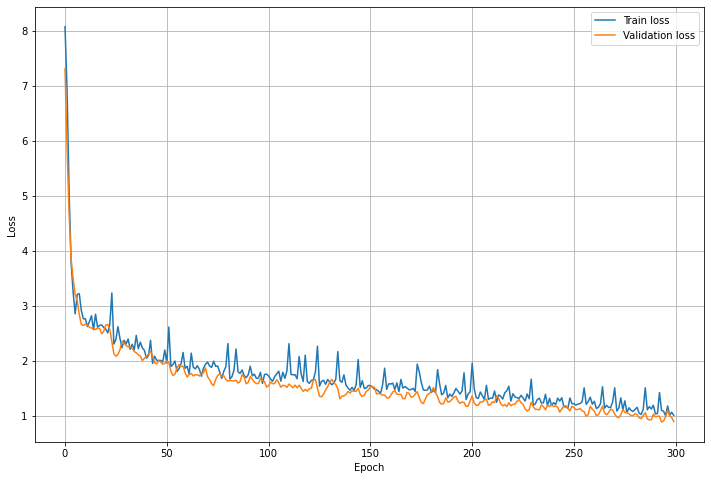

In [14]:
# Plot losses
plt.figure(figsize=(12,8))
#plt.semilogy
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [15]:
# Input vector
x_vec = torch.linspace(-5.5,5.5,1000).to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
model.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = model(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
#beta_true = [-1.45, 1.12, 2.3]
#true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


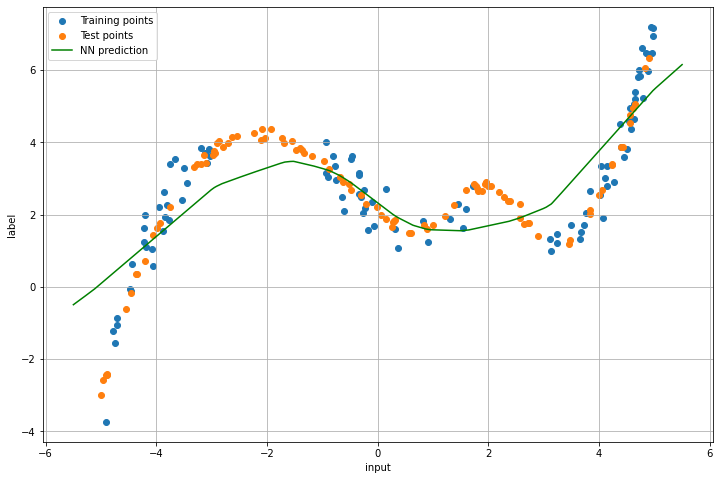

In [16]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.plot(x_vec, y_vec, label='NN prediction', color='green')
plt.xlabel('input')
plt.ylabel('label')
plt.grid()
plt.legend()
plt.show()

As we can see from the plot above, the network is not fitting well the points: this is an indication that the model choosen is perhaps too simple or the optimizer is not optimal. We are now going to perform an hyperparameters optimization to find a better set of parameters. 

# Optimization with cross-validation 

[Optuna](https://optuna.readthedocs.io/en/stable/#) is a software framework for automating the optimization process of of the hyperparameters of a neural network. It allows to choose from diffrent sampler algorithms, in our case, we'll make use of the *Random Search* sampler. An Optuna study has two main blocks:

- Objective function in which one specifies the hyperparameters to be considered, defines (or calls) the training loop and returns as output the object of the study.

- The Study creation (optuna.create_study) that defines the optimization session: one passes the objective function, specifies the number of trials and the direction of the study, which can be either to "minimize" or to "maximixe" the study object.


A trial corresponds to a single execution of the objective function to which a specific set of hyperparameter is associated; during the optimization, Optuna repeatedly calls and evaluates the objective function, and in the end  study.best_trial returns the best set of values found. 

## Optuna study

In the table we report the paramemeters considered during the tuning, the type of seach and the range considered. We have decided to study not only the optimizer and the learning rate associated, but also the number of units of the first and second hidden layer *units_1* and *units_2*; moreover we tune the regularization term *weight_decay*.


|Parameter | Type of search | Range |
| --- | --- | --- | 
| units_1 | int | [50,150] | 
| units_2 | int | [10,100] | 
| Optimizer | categorical | Adam,SDG |
| Learning rate (lr) | loguniform | [$10^{-5}$,$10^{-3}$] |
| Weight decay | loguniform | [$10^{-5}$,$10^{-2}$] |



As regards the type of search: *int* means it will sample an integer number between the given range, *categorical* suggest a value from the list for the categorical parameter, while *loguniform* will instead sample a floting value in the log domain for the continuous parameter. 

As mentioned before, the number of points is not plentiful, indeed splitting the dataset in train set and validation set has reduced even more the samples avaiable for training. To overcome this problem one can use a KFOLD cross-validation, that allows to repeat the training and validation across different splits of the original dataset. The general procedure is the following: 

1. Partition the training set of m samples into k folds of size m/k
2. For each fold:
    - Train on the union of the other folds
    - Estimate error on the selected fold
3. Estimate of the true error as the average of the estimated errors

The KFOLD cross validation is implemented inside the training loop of the objective function, the different folds (or splits) can be created thanks to the scikit-learn class [*KFold*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html). 

In [18]:
def objective(trial):

    param_dict ={
        #Number of hidden units in the middle layers.
        'units_1': trial.suggest_int('units_1', 50, 150),
        'units_2': trial.suggest_int('units_2', 10, 100),
        'loss': nn.MSELoss(),
         #Optimizer parameters + regularization (weight_norm)
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'SGD']),
        'lr': trial.suggest_loguniform('lr', 1e-5, 1e-3),
        'weight_norm': trial.suggest_loguniform('weigth_norm',1e-5, 1e-2),#Regularization
        'epochs': 300
         }    


    val_loss_f = []
    n_splits =4
    #KFOLD Cross Validation
    fold = KFold(n_splits=4, shuffle=True, random_state=seed)
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(range(len(train_dataset)))):
        train_data = torch.utils.data.Subset(train_dataset, train_idx)
        valid_data = torch.utils.data.Subset(train_dataset, valid_idx)

        train_loader = torch.utils.data.DataLoader(
          train_data,
          batch_size=10,
          shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
          valid_data,
          batch_size=5,
          shuffle=False #warnings, set to false
          )
        #print('------- FOLD',fold_idx,'-------')
        model = Net(1,param_dict['units_1'],param_dict['units_2'],1).to(device)
        train_loss, val_loss= model.train_step(train_loader, val_loader, param_dict)
        
        val_loss_f.append(np.mean(val_loss))
        val_loss = np.mean(val_loss_f)

    return val_loss

The two cells below where run ones to inizialize the study optimization and then to save the results of the study

In [19]:
#pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
#study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize")
#study.optimize(objective, n_trials=20, timeout=None, show_progress_bar=False)

In [20]:
#save_study = optuna.create_study(study_name="firststudy", direction="minimize", storage="sqlite:///regression.db")
#save_study.add_trials(study.trials)

In [21]:
study_load = optuna.load_study(study_name="firststudy", storage="sqlite:///regression.db")

## Study results

In [23]:
print("Number of finished trials: {}".format(len(study_load.trials)))

print("Best trial:")
best_trial = study_load.best_trial

print("  Value: {}".format(best_trial.value))

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 20
Best trial:
  Value: 0.20971079170703888
  Params: 
    lr: 0.0009037318994370232
    optimizer: Adam
    units_1: 113
    units_2: 85
    weigth_norm: 0.002508790684124125


In the plot below we explot on of Optuna feature to see which of the hyperparameters has the most importance during the optimization. In this regression study we can see that the learning rate *lr* is the most important one followed by the number of hidden units in the first layer *units_1*.

In [29]:
from optuna.visualization import plot_param_importances
plot_param_importances(study_load)

If there are any rendering problems, the plots are available at the following [link]( https://github.com/giorgettisabrina/NNDL/tree/main/homework1)

# Best model

We will now train the model on the full training dataset  with the best set of hyperparameters found with the Optuna study.


| Parameter | Value |
| --- | --- | 
| units_1| 113|
|units_2| 85|
|optimizer| Adam|
|lr| 0.0009|
|weigth_norm| 0.0025|


In [28]:
train_dataloader = DataLoader(train_data, batch_size=15, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)


In [29]:
best_model = Net(1,best_trial.params['units_1'],best_trial.params['units_2'],1)
best_model.to(device)


param_dict = {
    'epochs': 500,
    'loss':  nn.MSELoss(),
    'optimizer': best_trial.params['optimizer'],
    'lr': best_trial.params['lr'],
    'weight_norm': best_trial.params['weigth_norm']
    
}

btrain_loss, btest_loss  = best_model.train_step(train_dataloader, test_dataloader, param_dict)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.88it/s]


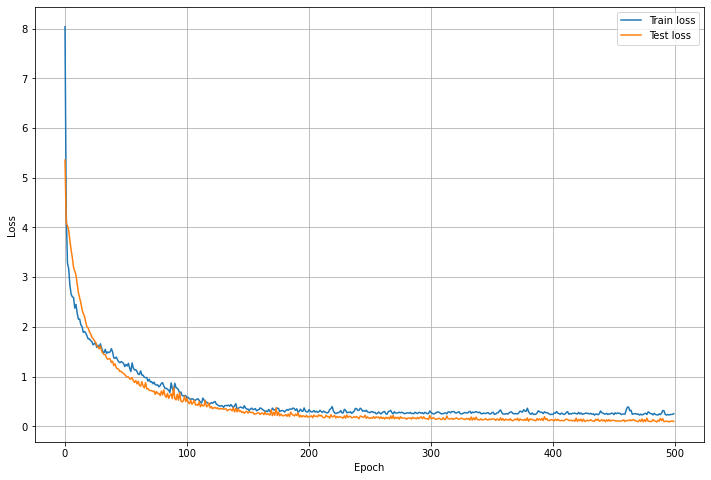

In [30]:
# Plot losses
plt.figure(figsize=(12,8))
#plt.semilogy
plt.plot(btrain_loss, label='Train loss')
plt.plot(btest_loss, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

As we can see from the plot, the trend of the loss is the one seached for: the loss is descreasing as the number of epochs increases. 

## Prediction

In [56]:
# Input vector
x_vec = torch.linspace(-5.2,5.2,200).to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
best_model.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = best_model(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
#beta_true = [-1.45, 1.12, 2.3]
#true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

Input shape: torch.Size([200, 1])
Output shape: torch.Size([200, 1])


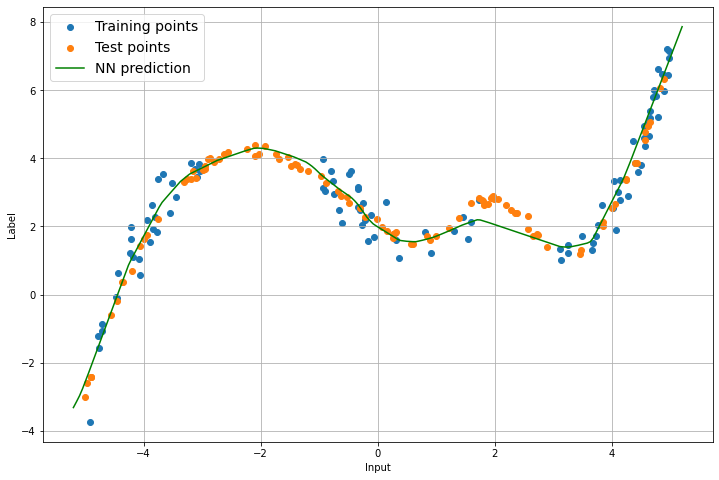

In [57]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.plot(x_vec, y_vec, label='NN prediction', color='green')
plt.xlabel('Input')
plt.ylabel('Label')
plt.grid()
plt.legend(fontsize=14)
plt.show()

In the figure above we can see how the network performs when predicting the ouputs for a novel set of data: the line fits well  points between $-4$ and $\sim 1.5$ and between  $\sim 2.5,5$, however it fails in a small interval around 2. One reason for this can be connected to the fact that no training points are present in that range and so the model is not able to generalize to trend, even if, we can notice a smaller peak with respect to that local maximum of the function. In the end, we can still assert that the network is able to approximate the function tendency. 

# Visualization

## Weights 

We visualize the histograms of the weights of the first,secon hidden layers and output layer to see how they are distributed, one can notice that the weights are finite and not exploding. 

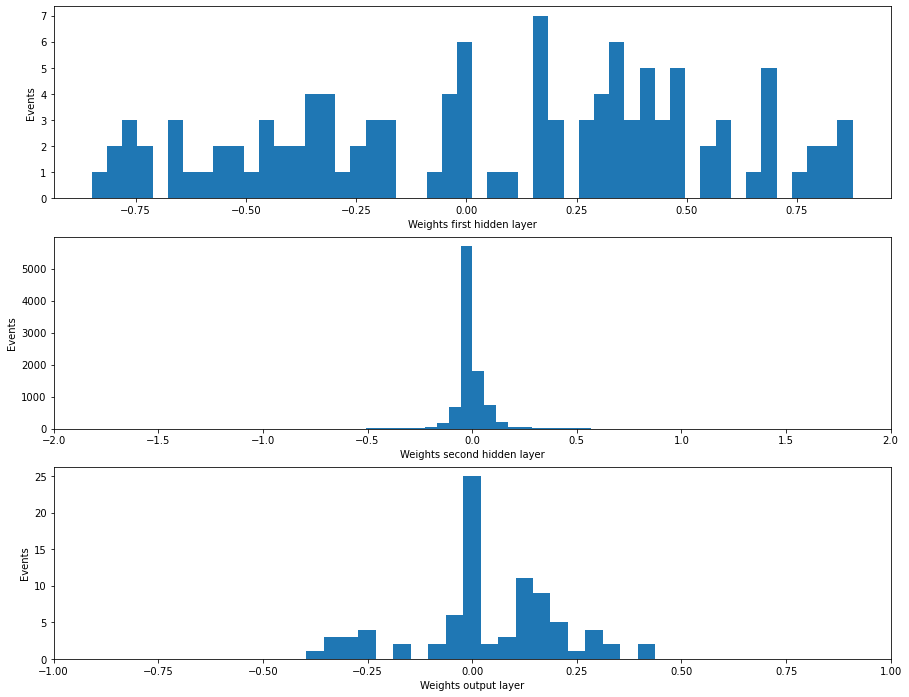

In [59]:
weight_fc1 = best_model.fc1.weight.data.cpu().numpy().flatten()
bias_fc1 = best_model.fc1.bias.data.cpu().numpy().flatten()

weight_fc2 = best_model.fc2.weight.data.cpu().numpy().flatten()
bias_fc2 = best_model.fc2.bias.data.cpu().numpy().flatten()

weight_out = best_model.out.weight.data.cpu().numpy().flatten()
bias_out = best_model.out.bias.data.cpu().numpy().flatten()


# Weights histogram
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.hist(weight_fc1, 50)
plt.ylabel('Events')
plt.xlabel('Weights first hidden layer')
plt.subplot(312)
plt.hist(weight_fc2, 20)
plt.ylabel('Events')
plt.xlabel('Weights second hidden layer')
plt.xlim(-2,2)
plt.subplot(313)
plt.hist(weight_out, 20)
plt.ylabel('Events')
plt.xlabel('Weights output layer')
plt.xlim(-1,1)

plt.show()

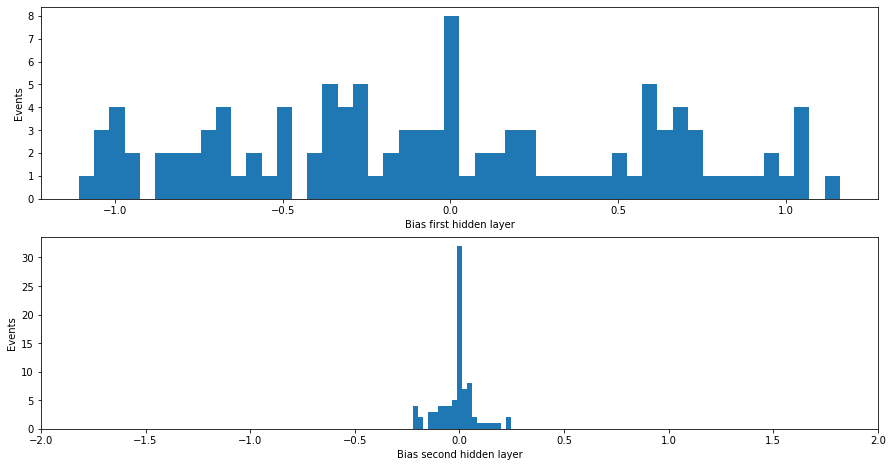

In [60]:
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.hist(bias_fc1, 50)
plt.ylabel('Events')
plt.xlabel('Bias first hidden layer')
plt.subplot(312)
plt.hist(bias_fc2, 20)
plt.ylabel('Events')
plt.xlabel('Bias second hidden layer')
plt.xlim(-2,2)
plt.show()



### Activation profiles

In this section we explore the activation profiles of the first and second hidden layer, for different inputs, though the register_forward_hook method [a](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html), [b](https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/). 
From the plots belowe we can see which neurons are firing and the different values reached (y-scale) for the different inputs.

In [61]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)


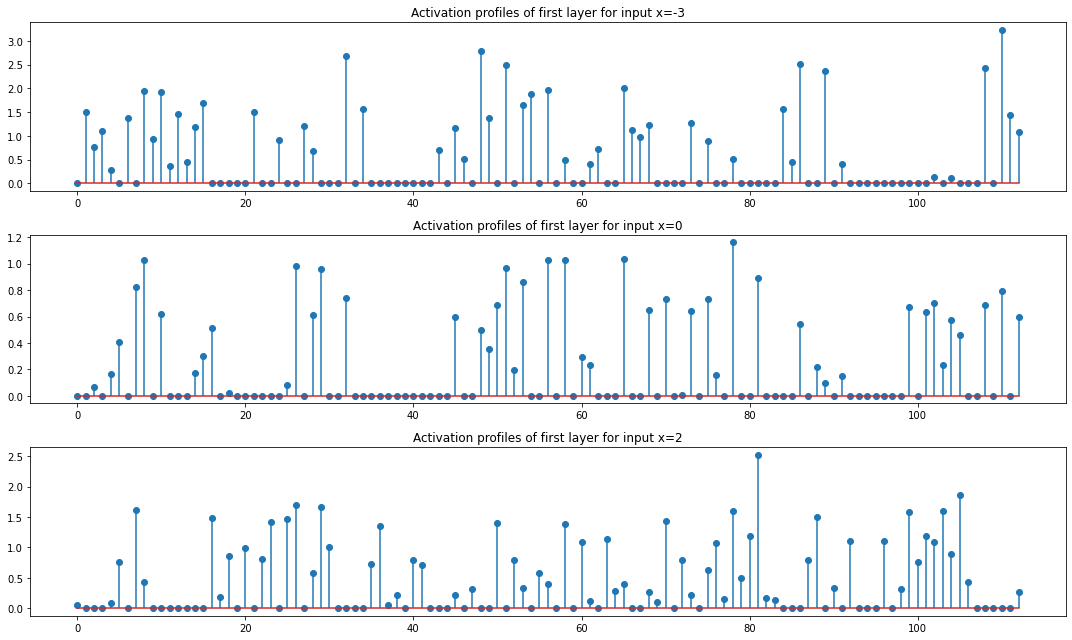

In [62]:
### Register hook  
hook_handle_fc1 = best_model.fc1.register_forward_hook(get_activation)

### Analyze activations
best_model.to(device).eval()
inputs = [-3, 0, 2]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list = []

with torch.no_grad():
    for inp in inputs_list:
        temp_y = best_model(inp.to(device))
        outputs_list.append(activation)

### Remove hook
hook_handle_fc1.remove()

plt.figure(figsize=(15,9))
for i, out in enumerate(outputs_list):
    plt.subplot(3,1,i+1)
    plt.stem(out.cpu().numpy(), use_line_collection=True)
    plt.title('Activation profiles of first layer for input x=%.f' % inputs[i])
plt.tight_layout()
plt.show()

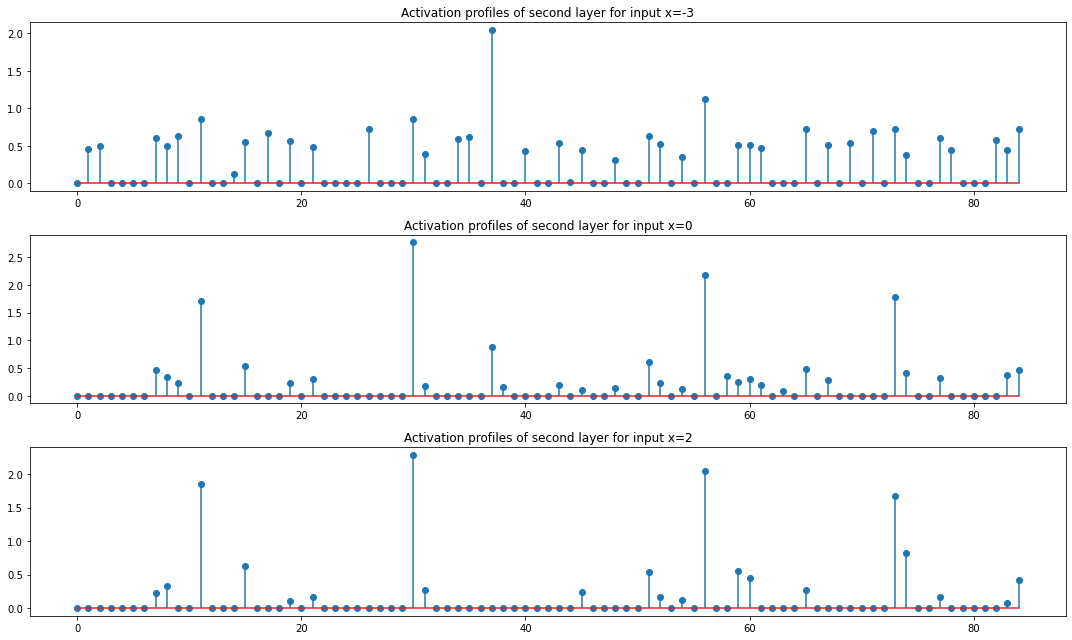

In [63]:
## Register hook  
hook_handle_fc2 = best_model.fc2.register_forward_hook(get_activation)

### Analyze activations
best_model.to(device).eval()
inputs = [-3, 0, 2]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list = []

with torch.no_grad():
    for inp in inputs_list:
        temp_y = best_model(inp.to(device))
        outputs_list.append(activation)

### Remove hook
hook_handle_fc2.remove()

plt.figure(figsize=(15,9))
for i, out in enumerate(outputs_list):
    plt.subplot(3,1,i+1)
    plt.stem(out.cpu().numpy(), use_line_collection=True)
    plt.title('Activation profiles of second layer for input x=%.f' % inputs[i])
plt.tight_layout()
plt.show()